In [218]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# Load MoM topline inflation
top_df = pd.read_csv('C:/Users/edgar/OneDrive/Code/data/MoM_Topline_inflation.csv')
# load Fed Funds rate
fed = pd.read_csv('C:/Users/edgar/OneDrive/Code/data/FEDFUNDS.csv')
# load Unemploymnet rate
unem = pd.read_csv('C:/Users/edgar/OneDrive/Code/data/UNRATENSA.csv')
# load US production - monthly pct change
prod = pd.read_csv('C:/Users/edgar/OneDrive/Code/data/IPB50001N_PCH.csv')

In [219]:
# plt.figure(figsize=(15, 8))
# sns.lineplot(data = fed)
# plt.show

In [220]:
# harmonize column name
unem.rename(columns={'observation_date': 'month'}, inplace=True)
fed.rename(columns={'observation_date': 'month'}, inplace=True)
prod.rename(columns={'observation_date': 'month'}, inplace=True)

top_df['month'] = pd.to_datetime(top_df['month'])
fed['month'] = pd.to_datetime(fed['month'])
unem['month'] = pd.to_datetime(unem['month'])
prod['month'] = pd.to_datetime(prod['month'])

merge = top_df.merge(fed, on='month', how='left')
merge = merge.merge(unem, on='month', how='left')
merge = merge.merge(prod, on='month', how='left')

# structural economic changes - dates: 2020 to most recent (July 2025)
merge = merge[merge['month'] >= '2020-01-01']

# After merging all data, convert ALL inflation columns to percentages
inflation_cols = [col for col in merge.columns if col not in ['month', 'month_num', 'FEDFUNDS', 'UNRATENSA', 'IPB50001N_PCH']]
for col in inflation_cols:
    merge[col] = merge[col] * 100

# create lags autoregressive lags of the target variable
merge['total_inflation_lag1'] = merge['total_inflation'].shift(1)
merge['total_inflation_lag2'] = merge['total_inflation'].shift(2)
merge['total_inflation_lag3'] = merge['total_inflation'].shift(3)

# lag for each macro variable
merge['FEDFUNDS_lag6'] = merge['FEDFUNDS'].shift(6)  # give time for transmission into goods demand
merge['UNRATENSA_lag3'] = merge['UNRATENSA'].shift(3)   # three month lag of unemployment rate - ppl reduce spending gradually as economy gradually changes
merge['IPB50001N_PCH_lag1'] = merge['IPB50001N_PCH'].shift(1)  # one month lag of US production - supply shocks move quickly through the economy

# Fed change
merge['fed_change'] = merge['FEDFUNDS'].diff()
merge['fed_change_lag3'] = merge['fed_change'].shift(3) # captures expectations/sentiments

merge = merge.dropna()

# lag_features + target variables
lag_features = ['total_inflation_lag1', 'total_inflation_lag2', 'total_inflation_lag3',
                'FEDFUNDS_lag6', 'UNRATENSA_lag3', 'IPB50001N_PCH_lag1', 'fed_change_lag3'] 
target = 'total_inflation'

month_dummies = pd.get_dummies(
    merge['month'].dt.month,
    prefix='m',
    drop_first=True
)

In [221]:
model_df

,total_inflation_lag1,total_inflation_lag2,total_inflation_lag3,FEDFUNDS_lag6,UNRATENSA_lag3,IPB50001N_PCH_lag1,fed_change_lag3,total_inflation,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
78,0.898409,0.899088,-1.489890,1.55,14.4,9.47902,-0.60,-1.415247,0,0,0,0,0,1,0,0,0,0,0
79,-1.415247,0.898409,0.899088,1.58,13.0,2.28963,0.00,0.626361,0,0,0,0,0,0,1,0,0,0,0
80,0.626361,-1.415247,0.898409,0.65,11.2,3.37425,0.03,1.223862,0,0,0,0,0,0,0,1,0,0,0
81,1.223862,0.626361,-1.415247,0.05,10.5,-2.54752,0.01,2.223992,0,0,0,0,0,0,0,0,1,0,0
82,2.223992,1.223862,0.626361,0.05,8.5,0.86594,0.01,-3.454185,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,-0.136513,2.319813,0.199831,5.13,3.8,0.72147,-0.16,0.375056,0,1,0,0,0,0,0,0,0,0,0
135,0.375056,-0.136513,2.319813,4.83,4.4,-0.12662,-0.15,0.130355,0,0,1,0,0,0,0,0,0,0,0
136,0.130355,0.375056,-0.136513,4.64,4.5,-1.84242,0.00,-0.254971,0,0,0,1,0,0,0,0,0,0,0
137,-0.254971,0.130355,0.375056,4.48,4.2,0.20184,0.00,-0.349665,0,0,0,0,1,0,0,0,0,0,0


In [224]:
# create a copy of the data for modeling
model_df = pd.concat(
    [merge[lag_features + [target]], month_dummies],
    axis=1
)

X = model_df.drop(columns=[target])
y = model_df[target]

# split the data into training and testing sets: SPLITS RANDOMLY!
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# TIME SERIES SPLIT (not random!)
train_size = int(len(X) * 0.85)
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# initialize and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# make predictions on the test set
y_predict = lr_model.predict(X_test)

# r2 = r2_score(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
# print(f"R^2 Score: {r2:.4f}")
print(f"Metrics for train/test (85/15) split")
print(f"---------------------------------")
print(f"Mean Squared Error: {mse}")
print(f"RMSE: {np.sqrt(mse):.6f}")

# Calculate directional accuracy
direction_correct = (np.sign(y_test) == np.sign(y_predict)) # assigns True/False
dir_accuracy = direction_correct.mean()

print(f"\nDirectional Accuracy: {dir_accuracy:.1%}")
print(f"  Correct on positive months: {(y_predict[y_test > 0] > 0).mean():.1%}")
print(f"  Correct on negative months: {(y_predict[y_test < 0] < 0).mean():.1%}")

Metrics for train/test (85/15) split
---------------------------------
Mean Squared Error: 0.5981416409579787
RMSE: 0.773396

Directional Accuracy: 80.0%
  Correct on positive months: 60.0%
  Correct on negative months: 100.0%


### Check Residuals of the model

In [193]:
residuals = y_test - y_predict
# Sum of resids on training data is 0 by OLS
# Sum/Mean of resids on test data is not necessarily 0 as shown below (want it to be for unbiasedness)

# Print residual statistics
print(f"Residual Statistics:")
print(f"Test set count: {len(residuals)}")
print(f"Mean of residuals: {residuals.mean():.4f}%  (should be near 0)")
print(f"Std Dev: {residuals.std():.4f}%")

Residual Statistics:
Test set count: 10
Mean of residuals: 0.4121%  (should be near 0)
Std Dev: 0.6898%


##### Walk-forward validation (cross-validation equivalent for time-series)
##### conclusion: Mean error across all folds is close enough to zero. The forecast is reasonably unbiased

Fold mean error: 1.0492%
Fold mean error: -1.1553%
Fold mean error: -0.0580%
Fold mean error: 1.0753%
Fold mean error: 0.4121%

Overall mean error: 0.2646% (reasonably close to 0; model is approx. unbiased)
Overall RMSE: 1.1463% (includes unrealistically small early training sets)


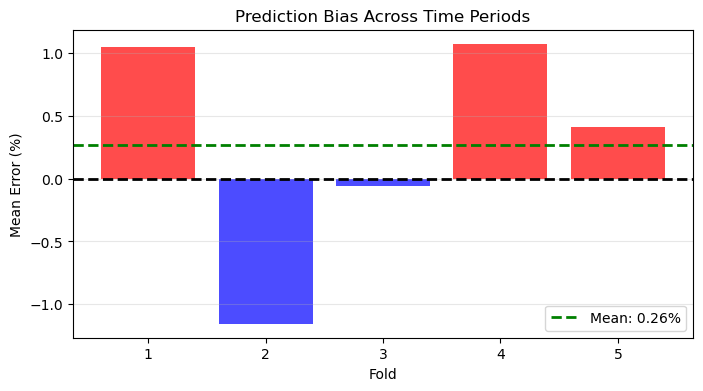

In [194]:
# training model on progressively more data.
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
all_residuals = []
rmse_scores = []
for train_idx, test_idx in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    
    model_cv = LinearRegression()
    model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = model_cv.predict(X_test_cv)
    
    residuals_cv = y_test_cv - y_pred_cv
    all_residuals.extend(residuals_cv)
    print(f"Fold mean error: {residuals_cv.mean():.4f}%")
    # Calculate RMSE for that fold
    mse_fold = mean_squared_error(y_test_cv, y_pred_cv)
    rmse_fold = np.sqrt(mse_fold)
    rmse_scores.append(rmse_fold)

print(f"\nOverall mean error: {np.mean(all_residuals):.4f}% (reasonably close to 0; model is approx. unbiased)")
print(f"Overall RMSE: {np.mean(rmse_scores):.4f}% (includes unrealistically small early training sets)")
# Plot errors across folds
fold_errors = [1.0492, -1.1553, -0.0580, 1.0753, 0.4121]

plt.figure(figsize=(8, 4))
plt.bar(range(1, 6), fold_errors, color=['red' if e > 0 else 'blue' for e in fold_errors], alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.axhline(y=np.mean(fold_errors), color='green', linestyle='--', linewidth=2, label=f'Mean: {np.mean(fold_errors):.2f}%')
plt.xlabel('Fold')
plt.ylabel('Mean Error (%)')
plt.title('Prediction Bias Across Time Periods')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

#### Check Residual Autocorrelation (missing parameters?)
##### "Is error[t] correlated with error[t-1]?"

     lb_stat  lb_pvalue
1  19.180661   0.000012
2  24.526527   0.000005
3  25.197261   0.000014
4  25.341545   0.000043
5  25.348622   0.000119


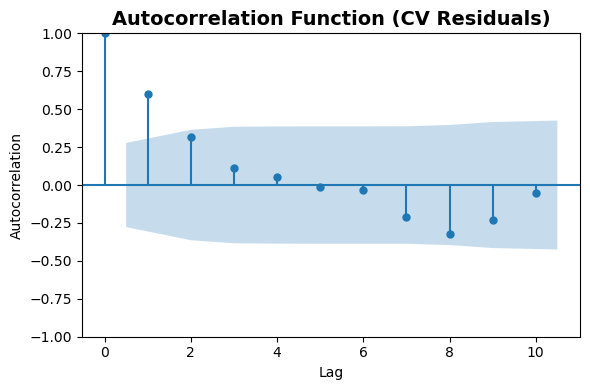

In [195]:
# Test autocorrelation on THESE
# check residual autocorrelation - if model's errors are correlated with past errors. correlation means not enough lags
lb_test = sm.stats.acorr_ljungbox(all_residuals, lags=[1, 2, 3, 4, 5], return_df=True)
print(lb_test)

# Plot ACF
fig, ax = plt.subplots(figsize=(6, 4))
sm.graphics.tsa.plot_acf(all_residuals, lags=10, ax=ax)
plt.title("Autocorrelation Function (CV Residuals)", fontsize=14, fontweight='bold')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

# NEED TO ADD LAG 4 AND SEE IF THIS CHANGES THE MODEL 
# ADDING LAG 4 MADE THE MODEL WORSE
# NEXT STEP: USE ARIMAX (ARIMA + EXOG) & USE AR(3) TERMS INSTEAD OF LAGS!

### ARIMAX Model (AR(3) + exog vars.)

    lb_stat  lb_pvalue
1  0.000631   0.979962
2  1.290737   0.524469
3  1.581165   0.663668
4  2.480416   0.648146
5  2.514792   0.774266


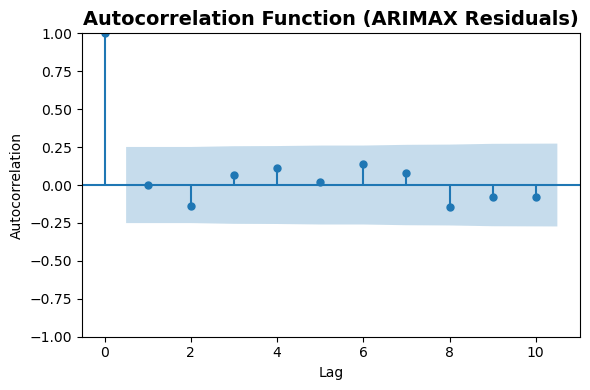

In [304]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
# Exogenous variables (no inflation lags)
exog_features = [
    'FEDFUNDS_lag6', 
    'UNRATENSA_lag3', 
    'IPB50001N_PCH_lag1', 
    'fed_change_lag3',
    'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 
    'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12'
]

model = SARIMAX(
    merge['total_inflation'],
    exog=model_df[exog_features],
    order=(1, 0, 0),  # AR(3)
    seasonal_order=(0, 0, 0, 0)
)

results = model.fit(disp=False)

# Check if autocorrelation is fixed
lb_test = sm.stats.acorr_ljungbox(results.resid, lags=[1,2,3,4,5])
print(lb_test)  #  p > 0.05!

fig, ax = plt.subplots(figsize=(6, 4))
sm.graphics.tsa.plot_acf(results.resid, lags=10, ax=ax)
plt.title("Autocorrelation Function (ARIMAX Residuals)", fontsize=14, fontweight='bold')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

### August Forecast
#### ARIMAX model

In [309]:
# ============================================
# FORECAST AUGUST 2025 WITH ARIMAX
# ============================================

# Get latest values (July 2025) from the SAME dataframe used for training
latest = model_df.iloc[-1]

# Create exogenous variables for August
next_month_exog = pd.DataFrame([{
    'FEDFUNDS_lag6': latest['FEDFUNDS_lag6'],  # Use the lag column directly
    'UNRATENSA_lag3': latest['UNRATENSA_lag3'],
    'IPB50001N_PCH_lag1': latest['IPB50001N_PCH_lag1'],
    'fed_change_lag3': latest['fed_change_lag3'],
    'm_2': 0, 'm_3': 0, 'm_4': 0, 'm_5': 0, 'm_6': 0,
    'm_7': 0, 'm_8': 1, 'm_9': 0, 'm_10': 0, 'm_11': 0, 'm_12': 0  # August = 1
}])

# Forecast August using the 'results' object from your training
forecast_result = results.get_forecast(steps=1, exog=next_month_exog)
aug_prediction = forecast_result.predicted_mean.values[0]

# Get 95% confidence interval
ci = forecast_result.conf_int()
ci_lower = ci.iloc[0, 0]
ci_upper = ci.iloc[0, 1]

# Display results
rmse_arimax = 0.92  # From your validation BELOW!

print(f"\n{'='*60}")
print(f"AUGUST 2025 FORECAST (ARIMAX MODEL)")
print(f"{'='*60}")
print(f"Prediction: {aug_prediction:.2f}%")
print(f"95% PI: [{ci_lower:.2f}%, {ci_upper:.2f}%]")
print(f"Direction: {'UP ⬆️' if aug_prediction > 0 else 'DOWN ⬇️'}")
print(f"\nModel Validation:")
print(f"  • RMSE: {rmse_arimax:.2f}%")
print(f"  • No autocorrelation (Ljung-Box p > 0.78)")
#print(f"  • ARIMAX AR(3) with {len(exog_features)} exogenous variables")
print(f"  • Training observations: {len(model_df)}")
print(f"{'='*60}")


AUGUST 2025 FORECAST (ARIMAX MODEL)
Prediction: 0.24%
95% PI: [-0.98%, 1.47%]
Direction: UP ⬆️

Model Validation:
  • RMSE: 0.92%
  • No autocorrelation (Ljung-Box p > 0.78)
  • Training observations: 61


### August Forecast
#### OLS Model and Forecast

In [307]:
# Use ALL observations (no train/test split)
X_full = model_df.drop(columns=[target])
y_full = model_df[target]

print(f"Training observations: {len(X_full)} (was {len(X_train)})")

# Train final model on ALL data
final_model = LinearRegression()
final_model.fit(X_full, y_full)
# ============================================================
# PREDICT AUGUST 2025
# ============================================================
latest = merge.iloc[-1]  # July 2025 data

# Core lagged features
next_month_df = pd.DataFrame([{
    'total_inflation_lag1': latest['total_inflation'],
    'total_inflation_lag2': merge.iloc[-2]['total_inflation'],
    'total_inflation_lag3': merge.iloc[-3]['total_inflation'],
    'FEDFUNDS_lag6': latest['FEDFUNDS'],
    'UNRATENSA_lag3': latest['UNRATENSA'],
    'IPB50001N_PCH_lag1': latest['IPB50001N_PCH'],
    'fed_change_lag3': latest['fed_change']
}])

# Month fixed effects (August = month 8)
for m in range(2, 13):
    next_month_df[f'm_{m}'] = 1 if m == 8 else 0

# Predict with FINAL model (trained on all data)
aug_prediction = final_model.predict(next_month_df)[0]

# Use RMSE from your 85/15 split for confidence interval
rmse = 0.7734  # Your previously calculated RMSE

print(f"\n{'='*50}")
print(f"August 2025 Forecast (OLS Final Model):")
print(f"  Prediction: {aug_prediction:.2f}%")
print(f"  95% Prediction Interval: [{aug_prediction - 1.96*rmse:.2f}%, {aug_prediction + 1.96*rmse:.2f}%]")
print(f"  Direction: {'UP ⬆️' if aug_prediction > 0 else 'DOWN ⬇️'}")
print(f"\nModel trained on: {len(X_full)} observations")
print(f"RMSE estimate: {rmse:.4f}% (from 85/15 validation)")
print(f"{'='*50}")

Training observations: 61 (was 51)

August 2025 Forecast (OLS Final Model):
  Prediction: 0.58%
  95% Prediction Interval: [-1.41%, 2.57%]
  Direction: UP ⬆️

Model trained on: 61 observations
RMSE estimate: 0.7734% (from 85/15 validation)


In [306]:
# ============================================
# ARIMAX 85/15 SPLIT FOR VALIDATION
# ============================================

# Split data
train_size = int(len(model_df) * 0.85)
train_data = model_df.iloc[:train_size]
test_data = model_df.iloc[train_size:]

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

# Train ARIMAX on training data only
arimax_train = SARIMAX(
    train_data['total_inflation'],
    exog=train_data[exog_features],
    order=(1, 0, 0),
    seasonal_order=(0, 0, 0, 0)
)

arimax_results_train = arimax_train.fit(disp=False)

# Forecast on test set
test_predictions = arimax_results_train.forecast(
    steps=len(test_data), 
    exog=test_data[exog_features]
)

# Calculate metrics
from sklearn.metrics import mean_squared_error, r2_score

y_test = test_data['total_inflation'].values
y_pred = test_predictions.values

rmse_arimax = np.sqrt(mean_squared_error(y_test, y_pred))
r2_arimax = r2_score(y_test, y_pred)

# Directional accuracy
dir_correct = (np.sign(y_test) == np.sign(y_pred)).sum()
dir_acc_arimax = dir_correct / len(y_test)

print(f"\n{'='*60}")
print(f"ARIMAX MODEL VALIDATION (85/15 SPLIT)")
print(f"{'='*60}")
print(f"RMSE: {rmse_arimax:.4f}%")
print(f"R²: {r2_arimax:.4f}")
print(f"Directional Accuracy: {dir_acc_arimax:.1%}")
print(f"  Positive months correct: {(y_pred[y_test > 0] > 0).mean():.1%}")
print(f"  Negative months correct: {(y_pred[y_test < 0] < 0).mean():.1%}")
print(f"{'='*60}")

# Compare to OLS
print(f"\nCOMPARISON:")
print(f"  OLS RMSE:    0.77%")
print(f"  ARIMAX RMSE: {rmse_arimax:.2f}%")
print(f"  {'ARIMAX is BETTER! ✅' if rmse_arimax < 0.77 else 'OLS was better'}")

Train size: 51
Test size: 10

ARIMAX MODEL VALIDATION (85/15 SPLIT)
RMSE: 0.9221%
R²: 0.5153
Directional Accuracy: 70.0%
  Positive months correct: 40.0%
  Negative months correct: 100.0%

COMPARISON:
  OLS RMSE:    0.77%
  ARIMAX RMSE: 0.92%
  OLS was better


### September Forecast

In [285]:
# Predict September 2025
# We'll use August prediction as lag1, and shift everything else
sept_month_df = pd.DataFrame([{
    'total_inflation_lag1': aug_prediction,                      # August forecast becomes lag1
    'total_inflation_lag2': latest['total_inflation'],           # July actual becomes lag2
    'total_inflation_lag3': merge.iloc[-2]['total_inflation'],   # June actual becomes lag3
    'FEDFUNDS_lag6': latest['FEDFUNDS'],
    'UNRATENSA_lag3': latest['UNRATENSA'],
    'IPB50001N_PCH_lag1': latest['IPB50001N_PCH'],
    'fed_change_lag3': latest['fed_change']
}])

# Month fixed effects (September = month 9)
for m in range(2, 13):
    sept_month_df[f'm_{m}'] = 1 if m == 9 else 0

# Predict using final_model (uses all data)
sept_prediction = final_model.predict(sept_month_df)[0]

print(f"\n{'='*50}")
print(f"September 2025 Forecast: {sept_prediction:.2f}%")
print(f"95% CI: [{sept_prediction - 1.96*rmse:.2f}%, {sept_prediction + 1.96*rmse:.2f}%]")
print(f"Direction: {'UP ⬆️' if sept_prediction > 0 else 'DOWN ⬇️'}")
print(f"{'='*50}")


September 2025 Forecast: 0.30%
95% CI: [-1.22%, 1.82%]
Direction: UP ⬆️


In [286]:
print("\nData Distribution:")
print(f"Total observations: {len(merge)}")
print(f"Positive inflation months: {(merge['total_inflation'] > 0).sum()} ({(merge['total_inflation'] > 0).mean():.1%})")
print(f"Negative inflation months: {(merge['total_inflation'] < 0).sum()} ({(merge['total_inflation'] < 0).mean():.1%})")
print(f"Mean inflation: {merge['total_inflation'].mean():.3f}%")
print(f"\nTest set:")
print(f"Positive months: {(y_test > 0).sum()}")
print(f"Negative months: {(y_test < 0).sum()}")


Data Distribution:
Total observations: 61
Positive inflation months: 31 (50.8%)
Negative inflation months: 30 (49.2%)
Mean inflation: -0.109%

Test set:
Positive months: 5
Negative months: 5


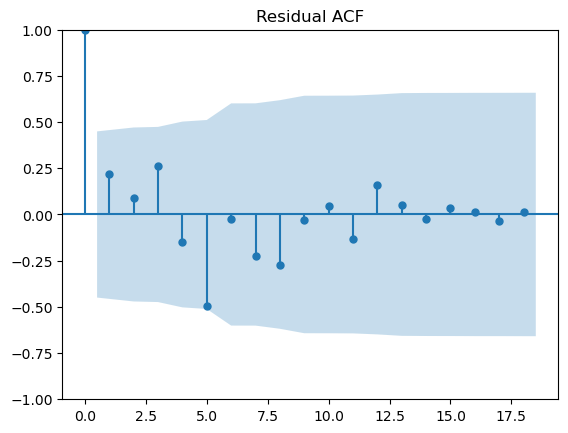

     lb_stat  lb_pvalue
9  15.082932   0.088683


### Ridge regression 
#### - very similar results

In [9]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)  # alpha controls regularization strength
ridge_model.fit(X_train, y_train)

y_predict = ridge_model.predict(X_test)
r2 = r2_score(y_test, y_predict)
# Calculate RMSE for confidence interval
rmse = np.sqrt(mean_squared_error(y_test, y_predict))

# Predict August 2025 using Ridge model
latest = merge.iloc[-1]
next_month_features = pd.DataFrame([{
    'total_inflation_lag1': latest['total_inflation'],
    'total_inflation_lag2': merge.iloc[-2]['total_inflation'],
    'total_inflation_lag3': merge.iloc[-3]['total_inflation'],
    'FEDFUNDS_lag6': latest['FEDFUNDS'],
    'UNRATENSA_lag3': latest['UNRATENSA'],
    'IPB50001N_PCH_lag1': latest['IPB50001N_PCH'],
    'fed_change_lag3': latest['fed_change'],
    'month_num': 8  # August
}])

aug_prediction = ridge_model.predict(next_month_features)[0]

print(f"\nAugust 2025 Forecast (Ridge): {aug_prediction:.2f}%")
print(f"95% CI: [{aug_prediction - 1.96*rmse:.2f}%, {aug_prediction + 1.96*rmse:.2f}%]")
print(f"Direction: {'UP ⬆️' if aug_prediction > 0 else 'DOWN ⬇️'}")
print(f"Ridge R²: {r2:.4f}")


August 2025 Forecast (Ridge): 0.62%
95% CI: [-1.79%, 3.03%]
Direction: UP ⬆️
Ridge R²: 0.1357
